# Forecasting Change in Global Average Land Temparature

The Climate Change: Earth Surface Temperature dataset provides records of the global average land temperature from 1750 to 2015. I will be using this dataset to see if I can train a model that can accurately forecast the temperature in the future, based on the temperature of previous years. The model will use one-step prediction to predict the average land temperature of the following year, based on a window of data about the previous years. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

In [2]:
data = pd.read_csv("GlobalTemperatures.csv")
print(data.shape)
data.head()

(3192, 9)


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data["dt"] = pd.to_datetime(data["dt"])
data = data[["dt", "LandAverageTemperature"]]
data.isnull().sum()

dt                         0
LandAverageTemperature    12
dtype: int64

In [4]:
data = data.dropna()
data.shape

(3180, 2)

In [5]:
data["Year"] = data.dt.dt.year
data = data.groupby(["Year"]).mean()
data

,LandAverageTemperature
Year,
1750,8.719364
1751,7.976143
1752,5.779833
1753,8.388083
1754,8.469333
...,...
2011,9.516000
2012,9.507333
2013,9.606500


I've taken the time series data which stores the average land temperature on every day of every year (between 1750 to 2015), and created a new time series so that I now just have the average land temperature for each year. 

In [6]:
data['LandAverageTemperature_log1p'] = np.log1p(data['LandAverageTemperature'])
data['LandAverageTemperature_log1p_diff'] = data['LandAverageTemperature_log1p'] - data['LandAverageTemperature_log1p'].shift(1)
data = data.drop("LandAverageTemperature_log1p", axis=1)
data = data.dropna()
data = data.reset_index()
data

,Year,LandAverageTemperature,LandAverageTemperature_log1p_diff
0,1751,7.976143,-0.079550
1,1752,5.779833,-0.280618
2,1753,8.388083,0.325489
3,1754,8.469333,0.008617
4,1755,8.355583,-0.012085
...,...,...,...
260,2011,9.516000,-0.017634
261,2012,9.507333,-0.000824
262,2013,9.606500,0.009394
263,2014,9.570667,-0.003384


I want to train on a stationary time series, therefore I've take log(x+1) of my time series, and created another new column that stores the change in average land temperature compared to the previous year.

Text(0.5, 1.0, 'Average Land Temperature - 1751-2015 - (Celcius)')

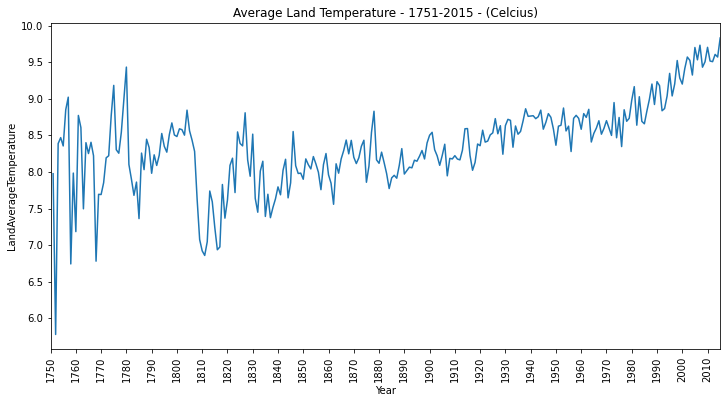

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=data.Year, y=data.LandAverageTemperature, ax=ax)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
ax.set_xlim(1750, 2015)
ax.set_title("Average Land Temperature - 1751-2015 - (Celcius)")

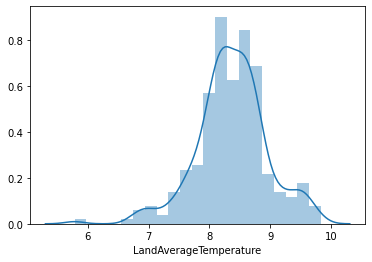

In [8]:
sns.distplot(data.LandAverageTemperature)

Text(0.5, 1.0, 'Difference in Average Land Temperature to Previous Year - 1751-2015 - (Celcius)')

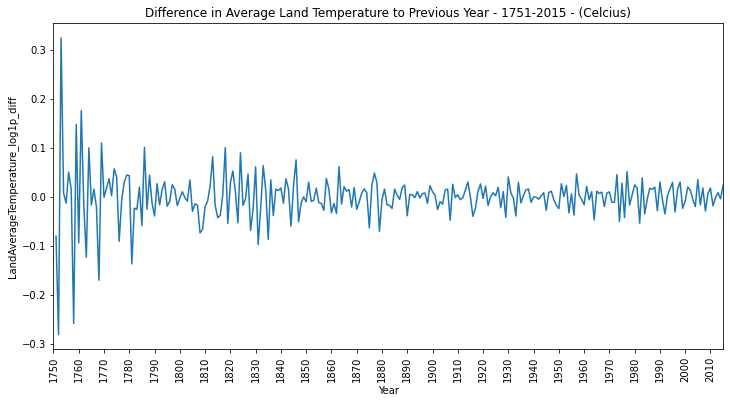

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(x=data.Year, y=data.LandAverageTemperature_log1p_diff, ax=ax)
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=30))
ax.set_xlim(1750, 2015)
ax.set_title("Difference in Average Land Temperature to Previous Year - 1751-2015 - (Celcius)")

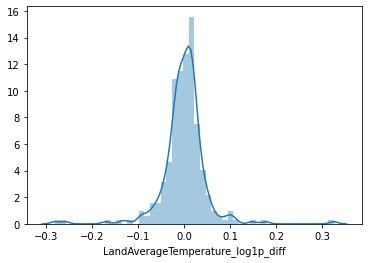

In [10]:
sns.distplot(data.LandAverageTemperature_log1p_diff)

# One-step LTSM Model

In [11]:
WINDOW_LENGTH = 20

The window length determines how many previous years of historical data will be used for the model to make predictions. For the one-step model, in order to predict the average temperature for a certain year, the model will use the previous 20 years of data.

In [12]:
train = data[data["Year"] < 1950]
test = data[data["Year"] >= 1950]

train = train.set_index("Year")
test = test.set_index("Year")

In [13]:
x_train = []
for i in range(WINDOW_LENGTH, train.shape[0] - 1):
    x_train.append(np.array(train.iloc[(i - WINDOW_LENGTH):i, 1].copy()).reshape(WINDOW_LENGTH, 1))
x_train = np.array(x_train)
y_train = np.array(train.iloc[WINDOW_LENGTH + 1:, 1].values).reshape(-1, 1)
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)

x_test = []
for i in range(WINDOW_LENGTH, test.shape[0] - 1):
    x_test.append(np.array(test.iloc[(i - WINDOW_LENGTH):i, 1].copy()).reshape(WINDOW_LENGTH, 1))
x_test = np.array(x_test)
y_test = np.array(test.iloc[WINDOW_LENGTH + 1:, 1].values).reshape(-1, 1)
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (178, 20, 1)
y train shape:  (178, 1)
X test shape:  (45, 20, 1)
y test shape:  (45, 1)


In [14]:
model = Sequential()
model.add(LSTM(50, input_shape=(WINDOW_LENGTH, 1)))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train, y_train, batch_size=32, validation_data=(x_test, y_test), epochs=6000, shuffle=True, verbose=0)

Train MAE: 0.0015283278045098922
Test MAE: 0.021401503904026477


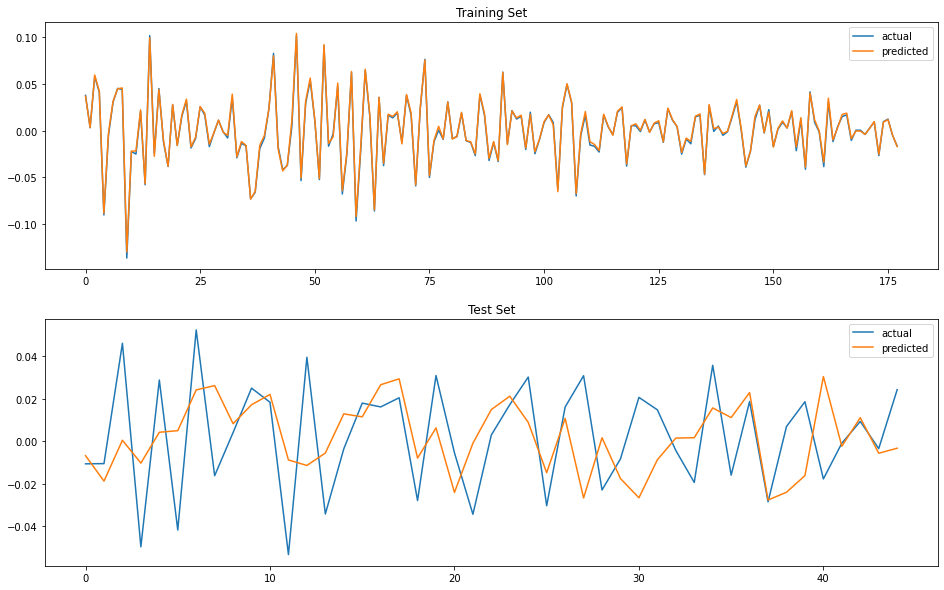

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

y_pred = model.predict(x_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train MAE: {}'.format(mae))

ax[0].plot(y_train, label="actual")
ax[0].plot(y_pred, label="predicted")
ax[0].set_title("Training Set")

y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {}'.format(mae))

ax[1].plot(y_test, label="actual")
ax[1].plot(y_pred, label="predicted")
ax[1].set_title("Test Set")

for ax in fig.axes:
    plt.sca(ax)
    plt.legend()
plt.show()

The model has fit well to the training data, however it's very messy at matching the test data. The train MAE of 0.00153 and test MAE of 0.0214 indicates that the model is overfitting. Let's convert the model's predictions back to average land temperature per year, rather than the change from the previous year, to see how the predicted forecast looks compared to the actual one. 

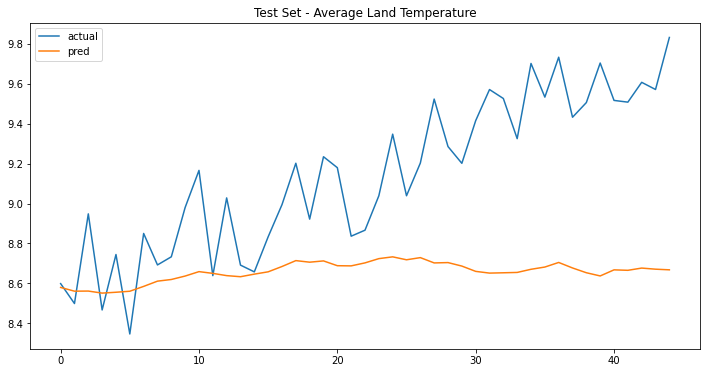

In [17]:
test_actual_avg_temp = np.array(test.iloc[WINDOW_LENGTH + 1:, 0].values)

pred_avg_temp = []
pred_avg_temp.append(train.iloc[-1:, 0].values[0])

for i in range(len(test_actual_avg_temp)):
    pred_avg_temp.append(pred_avg_temp[i] + y_pred[i,0])
    
plt.figure(figsize=(12,6))
plt.plot(test_actual_avg_temp, label="actual")
plt.plot(pred_avg_temp[1:], label="pred")
plt.legend()
plt.title("Test Set - Average Land Temperature")
plt.show()

The predicted forecast does not match the actual forecast very well at all here. It's underestimating the increase in temperature and does not follow the repeated up/down pattern of the actual forecast. 

# Conclusion
The one-step LTSM model has not been very successful at predicting the forecast for average land temperature, as seen from the graphs above. It seems that the model is overfitting, however even with testing out various model layers and hyperparameters, it's very difficult to improve the model beyond what it shown. I believe that there is just simply not enough data available to build a model with significantly better performance. Using the calculated average land temperature per year, there are only 265 values in the dataset to use in total. I could potentially try using the original dataset with 3192 values (average temperature per day), however it is far more noisy. 